In [64]:
import os
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model

In [112]:
TRAIN_RATIO = 0.7
VALIDATION_RATIO = 0.2
TEST_RATIO = 0.1

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Filter training data for digits 0 and 1
train_filter = np.isin(y_train, [0, 1])
x_train_filtered = x_train[train_filter]
y_train_filtered= y_train[train_filter]

# Filter test data for digits 0 and 1
test_filter = np.isin(y_test, [0, 1])
x_test_filtered = x_test[test_filter]
y_test_filtered = y_test[test_filter]
# Re-map labels to 0 and 1
y_train_filtered = np.where(y_train_filtered == 0, 0, 1)
y_test_filtered = np.where(y_test_filtered == 0, 0, 1)

# Normalize data
x_train_filtered = x_train_filtered.astype('float32') / 255.0
x_test_filtered = x_test_filtered.astype('float32') / 255.0

# Reshape data for RNN
x_train_filtered = np.expand_dims(x_train_filtered, axis=-1)  # Add channel dimension
x_test_filtered = np.expand_dims(x_test_filtered, axis=-1)    # Add channel dimension
X = np.concatenate([x_train_filtered,x_test_filtered])
y = np.concatenate([y_train_filtered,y_test_filtered])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=(1-TRAIN_RATIO))
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=((TEST_RATIO/(VALIDATION_RATIO+TEST_RATIO))))

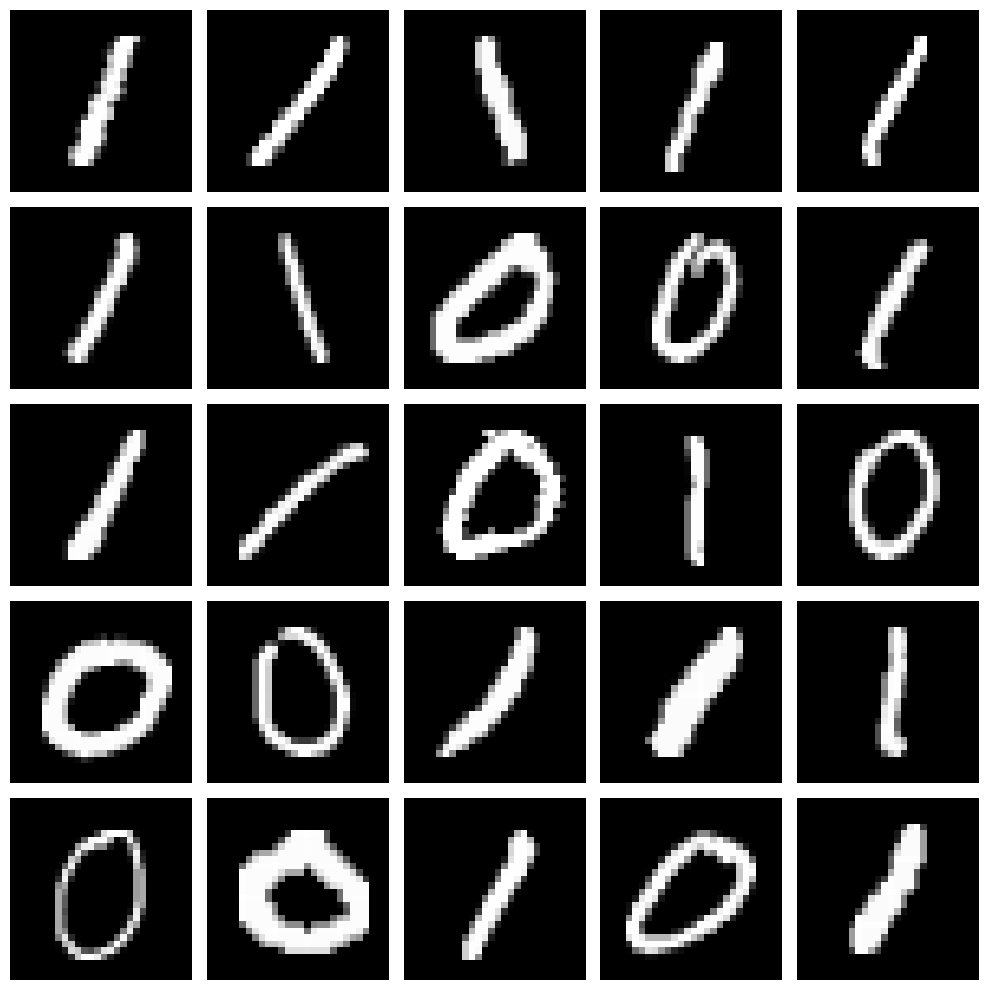

In [68]:
num_images = 25
indices = np.random.choice(x_train_filtered.shape[0], num_images, replace=False)

# Plot the images
fig, axes = plt.subplots(int(np.sqrt(num_images)), int(np.sqrt(num_images)), figsize=(10, 10))
axes = axes.flatten()

for i, index in enumerate(indices):
    ax = axes[i]
    ax.imshow(x_train_filtered[index], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 841ms/step - accuracy: 0.9291 - loss: 0.1790 - val_accuracy: 0.9970 - val_loss: 0.0233
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 828ms/step - accuracy: 0.9956 - loss: 0.0310 - val_accuracy: 0.9983 - val_loss: 0.0123
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 827ms/step - accuracy: 0.9976 - loss: 0.0178 - val_accuracy: 0.9986 - val_loss: 0.0068
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 827ms/step - accuracy: 0.9978 - loss: 0.0135 - val_accuracy: 0.9993 - val_loss: 0.0032
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 819ms/step - accuracy: 0.9988 - loss: 0.0060 - val_accuracy: 0.9993 - val_loss: 0.0011
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 822ms/step - accuracy: 0.9993 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 3.2169e-04
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 823ms/step - accuracy: 0.9993 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 2.7104e-04
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 828ms/step - accuracy: 0.9996 - loss: 0.0023 - val_acc

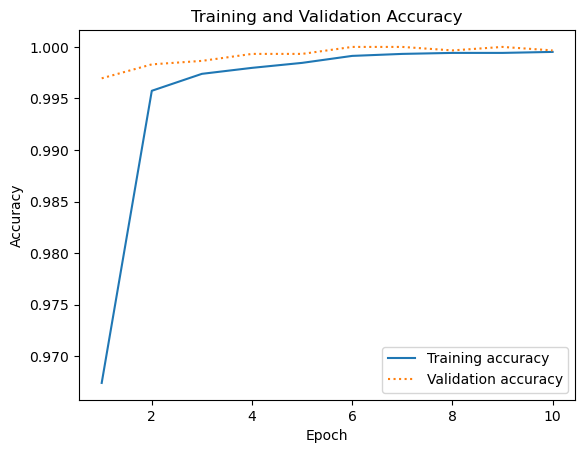

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


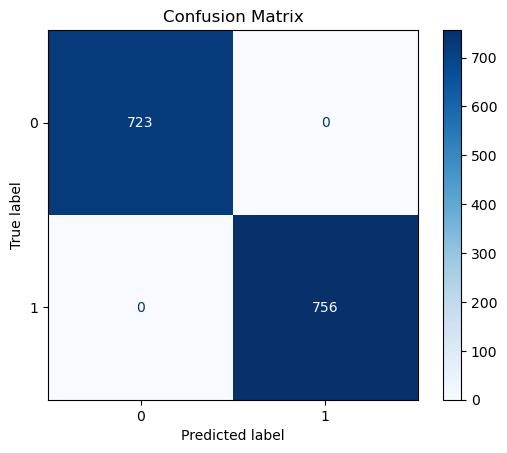

In [116]:
class CustomRNNCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(CustomRNNCell, self).__init__()
        self.units = units
        self.state_size = units
        self.W = self.add_weight(shape=(5184, units), initializer='random_normal', trainable=True)  # Updated
        self.U = self.add_weight(shape=(units, units), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(units,), initializer='zeros', trainable=True)

    def build(self, input_shape):
        num_excitatory = int(0.8 * self.units)
        num_inhibitory = self.units - num_excitatory
        self.neuron_types = np.concatenate([
            np.array(['E'] * num_excitatory),
            np.array(['I'] * num_inhibitory)
        ])

        connections = np.random.rand(self.units, self.units)
        np.fill_diagonal(connections, 0)

        self.connection_types = np.zeros((self.units, self.units), dtype='<U3')
        for i in range(self.units):
            for j in range(self.units):
                if self.neuron_types[i] == 'E' and self.neuron_types[j] == 'E':
                    self.connection_types[i, j] = 'E-E'
                elif self.neuron_types[i] == 'E' and self.neuron_types[j] == 'I':
                    self.connection_types[i, j] = 'E-I'
                elif self.neuron_types[i] == 'I' and self.neuron_types[j] == 'E':
                    self.connection_types[i, j] = 'I-E'
                elif self.neuron_types[i] == 'I' and self.neuron_types[j] == 'I':
                    self.connection_types[i, j] = 'I-I'

        self.W.assign(tf.random.normal((5184, self.units)))  # Updated

    def call(self, inputs, states):
        prev_output = states[0]
        output = tf.matmul(inputs, self.W) + tf.matmul(prev_output, self.U) + self.b
        output = tf.nn.relu(output)
        return output, [output]

units = 7835  # Adjust units as needed
custom_rnn_cell = CustomRNNCell(units)

conv_layers = [
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    #tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
]

for layer in conv_layers:
    layer.trainable = False

model = tf.keras.Sequential([
    *conv_layers,
    tf.keras.layers.Flatten(),  # Flatten the data for RNN
    tf.keras.layers.Reshape((1, -1)),  # Reshape to (batch_size, 1, features) for RNN
    tf.keras.layers.RNN(custom_rnn_cell, return_sequences=False),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
hist = model.fit(X_train, y_train, epochs=10, batch_size=1000, validation_data=(X_val, y_val))

# Plot training and validation accuracy
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig("Training Accuracy")
plt.show()

y_pred = model.predict(X_test)
# y_test = y_test.astype(int).tolist()
y_pred = np.round(y_pred).tolist()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig("Confusion Matrix")
plt.show()
